In [1]:
import tensorflow as tf
import erum_data_data as edd #import the erum_data_data module
import numpy as np
import matplotlib.pyplot as plt

In [21]:
ds = 'belle'
edd.print_description(ds)



SmartBKG dataset (Belle II - generated events passing downstream selection)

The goal of this classification problem is to identify generated events that pass a selection already before the expensive detector simulation and reconstruction.

Original dataset and additional information: https://github.com/kahn-jms/belle-selective-mc-dataset

----------------------------------    
Dataset shape:

Two sets of input data: 
- first set with shape:
    - 280000 belle collider events
    - 100 particles (zero padded)
    - 9 features ('prodTime', 'energy', 'x', 'y', 'z', 'px', 'py', 'pz', 'PID')
        - note: PID corresponding to a unique PDG particle ID, but mapped to a continous space
        
- second set with shape:
    - 280000 belle collider events
    - 100 indices of mother particles (adjacency matrix for creating a graph of the event)
        - note: these are -1 padded
---------------------------------- 
Label: 
event passes (1) or fails (0) a selection that was applied after det

In [22]:
# loading training data into RAM (downloads dataset first time)

X_train, y_train  = edd.load(ds, dataset='train', cache_dir = './'+ ds, cache_subdir = 'datasets')
X_test, y_test = edd.load(ds, dataset='test', cache_dir = './'+ ds, cache_subdir = 'datasets')

In [23]:
dim1 = X_train[0].shape[1]
dim2 = X_train[0].shape[2]
input2d = tf.keras.Input(shape = (dim1, dim2))
flatten = tf.keras.layers.Flatten()(input2d)
dense_1 = tf.keras.layers.Dense(256, activation = 'relu')(flatten)
dense_2 = tf.keras.layers.Dense(256, activation = 'relu')(dense_1)

if ds == 'airshower' or ds == 'belle':
    dim3 = X_train[1].shape[1]
    input1d = tf.keras.Input(shape = (dim3,))
    dense_3 = tf.keras.layers.Dense(256, activation = 'relu')(input1d)
    dense_4 = tf.keras.layers.Dense(256, activation = 'relu')(dense_3)
    merged  = tf.keras.layers.Concatenate(axis=1)([dense_2, dense_4])
    dense_5 = tf.keras.layers.Dense(256, activation = 'relu')(merged)
    inputs = [input2d, input1d]
else:
    inputs = [input2d]
    dense_5 = tf.keras.layers.Dense(256, activation = 'relu')(dense_2)

dense_6 = tf.keras.layers.Dense(256, activation = 'relu')(dense_5)
dense_7 = tf.keras.layers.Dense(256, activation = 'relu')(dense_6)
dense_8 = tf.keras.layers.Dense(256, activation = 'relu')(dense_7)
output  = tf.keras.layers.Dense(1, activation = 'sigmoid')(dense_8)
model = tf.keras.models.Model(inputs = inputs, outputs = output, name = "edd_model")

print(model.summary())
tf.keras.utils.plot_model(model)


Model: "edd_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100, 9)]     0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 900)          0           input_4[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 256)          230656      flatten_2[0][0]                  
__________________________________________________________________________________________

In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(name = "acc"), tf.keras.metrics.AUC(name = "AUC")],
)

history = model.fit(
                    x = X_train, y = y_train,
                    shuffle=True,
                    validation_split = 0.7,
                    epochs=10,
                    batch_size = 300,
                )

Train on 84000 samples, validate on 196000 samples
Epoch 1/10
84000/84000 [==============================] - 18s 217us/sample - loss: 0.9346 - acc: 0.5422 - AUC: 0.5578 - val_loss: 0.6798 - val_acc: 0.5586 - val_AUC: 0.5821
Epoch 2/10
84000/84000 [==============================] - 17s 205us/sample - loss: 0.6786 - acc: 0.5646 - AUC: 0.5906 - val_loss: 0.6805 - val_acc: 0.5628 - val_AUC: 0.5986
Epoch 3/10
84000/84000 [==============================] - 13s 153us/sample - loss: 0.6748 - acc: 0.5746 - AUC: 0.6035 - val_loss: 0.6800 - val_acc: 0.5605 - val_AUC: 0.6010
Epoch 4/10
84000/84000 [==============================] - 13s 159us/sample - loss: 0.6698 - acc: 0.5839 - AUC: 0.6179 - val_loss: 0.6688 - val_acc: 0.5853 - val_AUC: 0.6210
Epoch 5/10
84000/84000 [==============================] - 13s 150us/sample - loss: 0.6638 - acc: 0.5931 - AUC: 0.6327 - val_loss: 0.6678 - val_acc: 0.5885 - val_AUC: 0.6288
Epoch 6/10
84000/84000 [==============================] - 12s 148us/sample - loss: 0

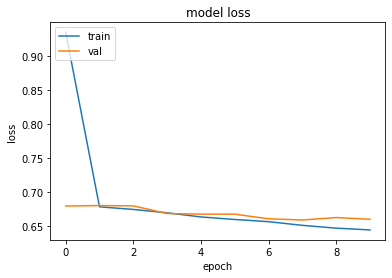

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

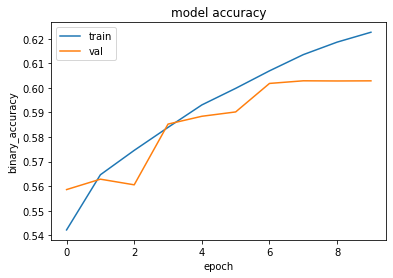

In [26]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

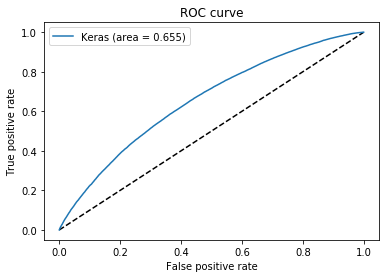

In [27]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_pred = model.predict(X_test).ravel()

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)

auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()